<font color='orange' size='7'>**Домашняя работа 1**</font>  
<font color='#11a642' size='6'>**Тема: Машинное обучение**</font>  
  

# <font color='#11a642' size='6'> **Импорт и установка библиотек**

In [100]:
import pandas as pd
import numpy as np
import zipfile
import pandas as pd

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, explained_variance_score, max_error, root_mean_squared_error
from sklearn.metrics import (precision_score, recall_score,
                             roc_auc_score, roc_curve, f1_score)

from sklearn.model_selection import (cross_val_score, GridSearchCV,
                                     RandomizedSearchCV, train_test_split)
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_regression
from sklearn.linear_model import HuberRegressor, Ridge

import plotly.graph_objects as go
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier

# функции, которые используются в проекте

In [2]:
def load_dataset(from_kaggle:bool = False) -> pd.DataFrame:
  '''
  Функция скачивает данные с сайта kaggle, если установлен from_kaggle=True,
  инчае архив считывается по ссылке с гугл диска (такой способ удобен тем, у кого нет доступа к kaggle)
  params:
      - from_kaggle - индикатор откуда скачивать данные (True - c сайта kaggle, False -  c google диска)
  return:
      - pd.DataFrame

  '''
  if from_kaggle:
    # запросит разрешение к гугл диску, необходимо дать это разрешение
    drive.mount('/content/drive')
    # установим kaggle
    !pip install kaggle -q
    !mkdir ~/.kaggle
    # копируем kaggle.json (предварительно, необходимо сгенерить токен на
    # сайте kaggle и сохранить к себе на гугл диск) в папку ~/.kaggle/
    !cp "/content/drive/MyDrive/Colab Notebooks/config/kaggle.json" ~/.kaggle/
    !kaggle competitions download -c playground-series-s4e12
  else:
    !gdown 1-730JF1IWA5e_ejuXWLmkkzHFvudisdp
  # распаковка архива
  zip_ref = zipfile.ZipFile('playground-series-s4e12.zip', 'r')
  zip_ref.extractall()
  zip_ref.close()
  df_train = pd.read_csv('train.csv')
  df_test = pd.read_csv('test.csv')
  df_sample_submission = pd.read_csv('sample_submission.csv')
  return df_train, df_test, df_sample_submission

In [3]:
 def get_plots(model, df_train, df_test, y_train, y_test):
    pred_test = model.predict(df_test)
    pred_train = model.predict(df_train)

    # Сравнение факта и прогноза
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.scatterplot(x=pred_test, y=y_test, ax=axes[0], alpha=0.7)
    axes[0].set_title("Test Data")
    axes[0].set_xlabel("Прогноз")
    axes[0].set_ylabel("Факт")

    sns.scatterplot(x=pred_train, y=y_train, ax=axes[1], alpha=0.7)
    axes[1].set_title("Train Data")
    axes[1].set_xlabel("Прогноз")
    axes[1].set_ylabel("Факт")

    fig.suptitle("Сравнение факта и прогноза", ha='center')
    plt.tight_layout()
    plt.show()

    # Сравнение остатков
    resid_test = pred_test - y_test
    resid_train = pred_train - y_train

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(resid_test, bins=15, ax=axes[0], kde=True, color='blue')
    axes[0].set_title("Test Residuals")
    axes[0].set_xlabel("Остатки")
    axes[0].set_ylabel("Частота")

    sns.histplot(resid_train, bins=15, ax=axes[1], kde=True, color='orange')
    axes[1].set_title("Train Residuals")
    axes[1].set_xlabel("Остатки")
    axes[1].set_ylabel("Частота")

    fig.suptitle("Сравнение остатков", ha='center')
    plt.tight_layout()
    plt.show()

    # График Q-Q
    quantiles_test_pred = np.percentile(pred_test, np.linspace(0, 100, num=200))
    quantiles_test_fact = np.percentile(y_test, np.linspace(0, 100, num=200))

    quantiles_train_pred = np.percentile(pred_train, np.linspace(0, 100, num=200))
    quantiles_train_fact = np.percentile(y_train, np.linspace(0, 100, num=200))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.scatterplot(x=quantiles_test_pred, y=quantiles_test_fact, ax=axes[0])
    axes[0].set_title("Test Q-Q Plot")
    axes[0].set_xlabel("Прогнозируемые Квантили")
    axes[0].set_ylabel("Фактические Квантили")

    sns.scatterplot(x=quantiles_train_pred, y=quantiles_train_fact, ax=axes[1])
    axes[1].set_title("Train Q-Q Plot")
    axes[1].set_xlabel("Прогнозируемые Квантили")
    axes[1].set_ylabel("Фактические Квантили")

    fig.suptitle("График Q-Q", ha='center')
    plt.tight_layout()
    plt.show()


In [4]:
df_train, df_test, df_sample_submission = load_dataset(from_kaggle= False)

Downloading...
From (original): https://drive.google.com/uc?id=1-730JF1IWA5e_ejuXWLmkkzHFvudisdp
From (redirected): https://drive.google.com/uc?id=1-730JF1IWA5e_ejuXWLmkkzHFvudisdp&confirm=t&uuid=c951138e-ce80-43f7-88df-7d209a993068
To: /content/playground-series-s4e12.zip
100% 79.1M/79.1M [00:02<00:00, 33.5MB/s]


In [5]:
df_train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [6]:
pd.set_option('display.max_columns', 100)

In [7]:
# Проверим на дубликаты
df_train.duplicated().sum()

0

In [8]:
# Заменинм название столбцов на нижний регистр и соединим нижним подчеркиваением
df_train.columns = [col.lower().replace('?', '').rstrip().replace(' ', '_').replace('/', '_') for col in df_train]

## <font color='#11a642' size='5'> Определим роли для независимых признаков

In [9]:
# Разабьем наши столбцы на категориальные и числовые
id = ['id', 'policy_start_date'] # столбец ID
target = 'premium_amount' # столбец с целевой переменной

features_cat = [col for col in df_train.select_dtypes(exclude='number').columns if col != id and col !=target]
features_num = [col for col in df_train.select_dtypes(include='number').columns if col != id and col !=target]

# <font color='#11a642' size='6'> **Разведочный анализ данных**

## <font color='#11a642' size='5'> Оцените размер вашего датасета


1.   Сколько ГБ ваш датасет
2.   Сколько строк и столбцов

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   age                   1181295 non-null  float64
 2   gender                1200000 non-null  object 
 3   annual_income         1155051 non-null  float64
 4   marital_status        1181471 non-null  object 
 5   number_of_dependents  1090328 non-null  float64
 6   education_level       1200000 non-null  object 
 7   occupation            841925 non-null   object 
 8   health_score          1125924 non-null  float64
 9   location              1200000 non-null  object 
 10  policy_type           1200000 non-null  object 
 11  previous_claims       835971 non-null   float64
 12  vehicle_age           1199994 non-null  float64
 13  credit_score          1062118 non-null  float64
 14  insurance_duration    1199999 non-

In [11]:
df_train.describe()

,id,age,annual_income,number_of_dependents,health_score,previous_claims,vehicle_age,credit_score,insurance_duration,premium_amount
count,1.200000e+06,1.181295e+06,1.155051e+06,1.090328e+06,1.125924e+06,835971.000000,1.199994e+06,1.062118e+06,1.199999e+06,1.200000e+06
mean,5.999995e+05,4.114556e+01,3.274522e+04,2.009934e+00,2.561391e+01,1.002689,9.569889e+00,5.929244e+02,5.018219e+00,1.102545e+03
std,3.464103e+05,1.353995e+01,3.217951e+04,1.417338e+00,1.220346e+01,0.982840,5.776189e+00,1.499819e+02,2.594331e+00,8.649989e+02
min,0.000000e+00,1.800000e+01,1.000000e+00,0.000000e+00,2.012237e+00,0.000000,0.000000e+00,3.000000e+02,1.000000e+00,2.000000e+01
25%,2.999998e+05,3.000000e+01,8.001000e+03,1.000000e+00,1.591896e+01,0.000000,5.000000e+00,4.680000e+02,3.000000e+00,5.140000e+02
50%,5.999995e+05,4.100000e+01,2.391100e+04,2.000000e+00,2.457865e+01,1.000000,1.000000e+01,5.950000e+02,5.000000e+00,8.720000e+02
75%,8.999992e+05,5.300000e+01,4.463400e+04,3.000000e+00,3.452721e+01,2.000000,1.500000e+01,7.210000e+02,7.000000e+00,1.509000e+03
max,1.199999e+06,6.400000e+01,1.499970e+05,4.000000e+00,5.897591e+01,9.000000,1.900000e+01,8.490000e+02,9.000000e+00,4.999000e+03


In [12]:
df_train.dtypes

,0
id,int64
age,float64
gender,object
annual_income,float64
marital_status,object
number_of_dependents,float64
education_level,object
occupation,object
health_score,float64
location,object


In [13]:
# числовые признаки
features_num

['id',
 'age',
 'annual_income',
 'number_of_dependents',
 'health_score',
 'previous_claims',
 'vehicle_age',
 'credit_score',
 'insurance_duration']

In [14]:
# Категориальные признаки
features_cat

['gender',
 'marital_status',
 'education_level',
 'occupation',
 'location',
 'policy_type',
 'policy_start_date',
 'customer_feedback',
 'smoking_status',
 'exercise_frequency',
 'property_type']

**ВЫВОД**

Датафрейм содержит 1200000 строк и 21 столбец

В датафрейме 1 столбец - ID, 11 столбцов типа object и 10 столбцов числовые
 192.3+ MB



In [15]:
# Анализ пропущенных значений
df_train.isna().sum()

,0
id,0
age,18705
gender,0
annual_income,44949
marital_status,18529
number_of_dependents,109672
education_level,0
occupation,358075
health_score,74076
location,0


## <font color='#11a642' size='5'> Анализ числовых (непрерывных) признаков

In [16]:
# Рассмторим наш таргет
df_train['premium_amount'].describe()

,premium_amount
count,1.200000e+06
mean,1.102545e+03
std,8.649989e+02
min,2.000000e+01
25%,5.140000e+02
50%,8.720000e+02
75%,1.509000e+03
max,4.999000e+03


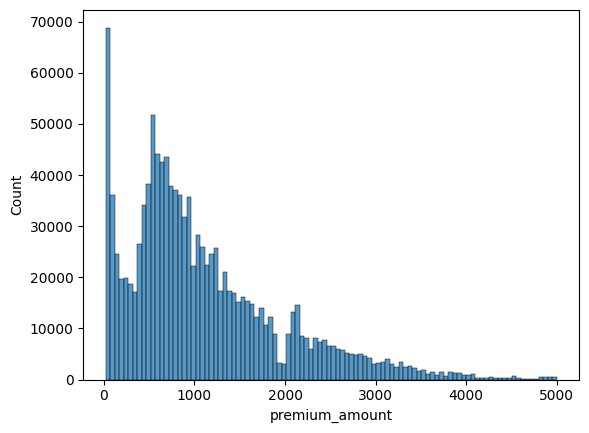

In [17]:
#  посмотрим на графике
sns.histplot(df_train['premium_amount'], bins=100)
plt.show()

In [18]:
df_train.describe()

,id,age,annual_income,number_of_dependents,health_score,previous_claims,vehicle_age,credit_score,insurance_duration,premium_amount
count,1.200000e+06,1.181295e+06,1.155051e+06,1.090328e+06,1.125924e+06,835971.000000,1.199994e+06,1.062118e+06,1.199999e+06,1.200000e+06
mean,5.999995e+05,4.114556e+01,3.274522e+04,2.009934e+00,2.561391e+01,1.002689,9.569889e+00,5.929244e+02,5.018219e+00,1.102545e+03
std,3.464103e+05,1.353995e+01,3.217951e+04,1.417338e+00,1.220346e+01,0.982840,5.776189e+00,1.499819e+02,2.594331e+00,8.649989e+02
min,0.000000e+00,1.800000e+01,1.000000e+00,0.000000e+00,2.012237e+00,0.000000,0.000000e+00,3.000000e+02,1.000000e+00,2.000000e+01
25%,2.999998e+05,3.000000e+01,8.001000e+03,1.000000e+00,1.591896e+01,0.000000,5.000000e+00,4.680000e+02,3.000000e+00,5.140000e+02
50%,5.999995e+05,4.100000e+01,2.391100e+04,2.000000e+00,2.457865e+01,1.000000,1.000000e+01,5.950000e+02,5.000000e+00,8.720000e+02
75%,8.999992e+05,5.300000e+01,4.463400e+04,3.000000e+00,3.452721e+01,2.000000,1.500000e+01,7.210000e+02,7.000000e+00,1.509000e+03
max,1.199999e+06,6.400000e+01,1.499970e+05,4.000000e+00,5.897591e+01,9.000000,1.900000e+01,8.490000e+02,9.000000e+00,4.999000e+03


In [19]:
# Будем строить модель только на числовых данных. Поэтому удалим категорильные столбцы

In [20]:
# удаление столбцов
df_train_1 = df_train.drop(['gender',
 'marital_status',
 'education_level',
 'occupation',
 'location',
 'policy_type',
 'policy_start_date',
 'customer_feedback',
 'smoking_status',
 'exercise_frequency',
 'property_type'], axis=1)

In [21]:
# Рассмотрим числовые столбцы

In [22]:
df_train_1.describe(), df_train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   age                   1181295 non-null  float64
 2   annual_income         1155051 non-null  float64
 3   number_of_dependents  1090328 non-null  float64
 4   health_score          1125924 non-null  float64
 5   previous_claims       835971 non-null   float64
 6   vehicle_age           1199994 non-null  float64
 7   credit_score          1062118 non-null  float64
 8   insurance_duration    1199999 non-null  float64
 9   premium_amount        1200000 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 91.6 MB


(                 id           age  annual_income  number_of_dependents  \
 count  1.200000e+06  1.181295e+06   1.155051e+06          1.090328e+06   
 mean   5.999995e+05  4.114556e+01   3.274522e+04          2.009934e+00   
 std    3.464103e+05  1.353995e+01   3.217951e+04          1.417338e+00   
 min    0.000000e+00  1.800000e+01   1.000000e+00          0.000000e+00   
 25%    2.999998e+05  3.000000e+01   8.001000e+03          1.000000e+00   
 50%    5.999995e+05  4.100000e+01   2.391100e+04          2.000000e+00   
 75%    8.999992e+05  5.300000e+01   4.463400e+04          3.000000e+00   
 max    1.199999e+06  6.400000e+01   1.499970e+05          4.000000e+00   
 
        health_score  previous_claims   vehicle_age  credit_score  \
 count  1.125924e+06    835971.000000  1.199994e+06  1.062118e+06   
 mean   2.561391e+01         1.002689  9.569889e+00  5.929244e+02   
 std    1.220346e+01         0.982840  5.776189e+00  1.499819e+02   
 min    2.012237e+00         0.000000  0.000000

In [23]:
df_train_1

,id,age,annual_income,number_of_dependents,health_score,previous_claims,vehicle_age,credit_score,insurance_duration,premium_amount
0,0,19.0,10049.0,1.0,22.598761,2.0,17.0,372.0,5.0,2869.0
1,1,39.0,31678.0,3.0,15.569731,1.0,12.0,694.0,2.0,1483.0
2,2,23.0,25602.0,3.0,47.177549,1.0,14.0,NaN,3.0,567.0
3,3,21.0,141855.0,2.0,10.938144,1.0,0.0,367.0,1.0,765.0
4,4,21.0,39651.0,1.0,20.376094,0.0,8.0,598.0,4.0,2022.0
...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,36.0,27316.0,0.0,13.772907,NaN,5.0,372.0,3.0,1303.0
1199996,1199996,54.0,35786.0,NaN,11.483482,NaN,10.0,597.0,4.0,821.0
1199997,1199997,19.0,51884.0,0.0,14.724469,0.0,19.0,NaN,6.0,371.0
1199998,1199998,55.0,NaN,1.0,18.547381,1.0,7.0,407.0,4.0,596.0


1.   Обработка пропусков


## <font color='#11a642' size='5'> Анализ пропусков

In [24]:
df_train_1.isna().sum()

,0
id,0
age,18705
annual_income,44949
number_of_dependents,109672
health_score,74076
previous_claims,364029
vehicle_age,6
credit_score,137882
insurance_duration,1
premium_amount,0


In [25]:
# Посмотрим процентное соотношение пропусков
for col in df_train_1.columns:
  print(f'{col}: {df_train_1[col].isna().sum() / df_train_1.shape[0] * 100:.2f}%')

id: 0.00%
age: 1.56%
annual_income: 3.75%
number_of_dependents: 9.14%
health_score: 6.17%
previous_claims: 30.34%
vehicle_age: 0.00%
credit_score: 11.49%
insurance_duration: 0.00%
premium_amount: 0.00%


<Axes: >

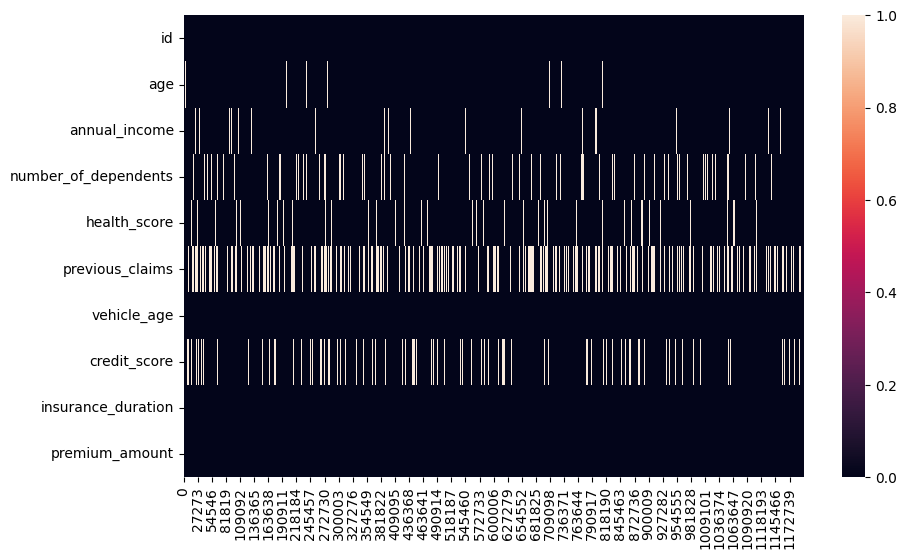

In [26]:
# Построим тепловую карту по нашим данным
plt.figure(figsize=(10, 6))
sns.heatmap(df_train_1.isna().transpose())

In [27]:
# Заполним пропуски в столбцах

In [28]:
# health_score

In [29]:
# Построим медиану и среднее заняения для данного столбца
df_train_1['health_score'].median()

24.57864816412784

In [30]:
df_train_1['health_score'].mean()

25.613907692519252

<Axes: ylabel='Frequency'>

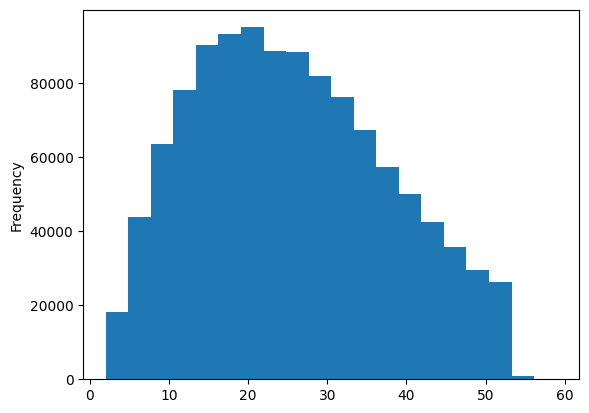

In [31]:
# Построим график
df_train_1['health_score'].plot(kind= 'hist', bins =20)

In [32]:
# Заменим на медиану, так как она более усточива к выбросам
df_train_1['health_score'].fillna(df_train_1['health_score'].median(), inplace= True)

In [33]:
for col in df_train_1.columns:
  print(f'{col}: {df_train_1[col].isna().sum() / df_train_1.shape[0] * 100:.2f}%')

id: 0.00%
age: 1.56%
annual_income: 3.75%
number_of_dependents: 9.14%
health_score: 0.00%
previous_claims: 30.34%
vehicle_age: 0.00%
credit_score: 11.49%
insurance_duration: 0.00%
premium_amount: 0.00%


<Axes: ylabel='Frequency'>

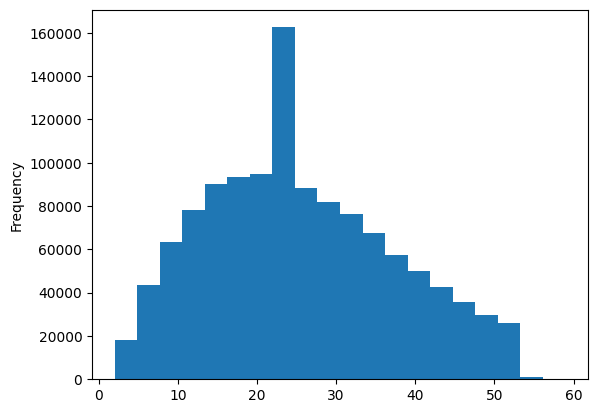

In [34]:
# Проверим распреление на графике после звполнения
df_train_1['health_score'].plot(kind= 'hist', bins =20)

In [35]:
#  credit_score
# Заменим на медиану, так как она более усточива к выбросам
df_train_1['credit_score'].fillna(df_train_1['credit_score'].median(), inplace= True)

<ipython-input-35-405eab3b664f>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_1['credit_score'].fillna(df_train_1['credit_score'].median(), inplace= True)


<Axes: ylabel='Frequency'>

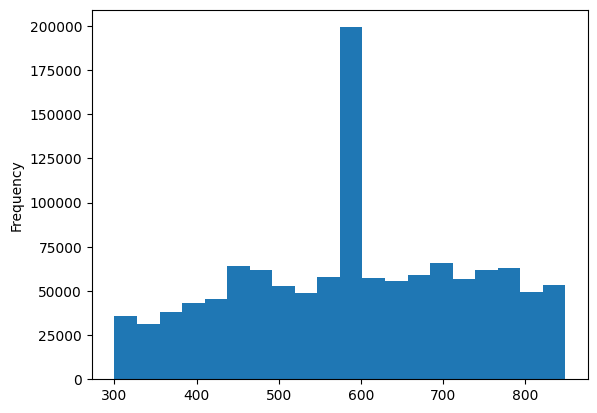

In [36]:
# Посмотрим распредение данных нашего столбца на гарфике
df_train_1['credit_score'].plot(kind= 'hist', bins = 20)

In [37]:
#  previous_claims
# Заменим на среднее
df_train_1['previous_claims'].fillna(df_train_1['previous_claims'].mean(), inplace= True)

<ipython-input-37-04ad0af4252f>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_1['previous_claims'].fillna(df_train_1['previous_claims'].mean(), inplace= True)


<Axes: ylabel='Frequency'>

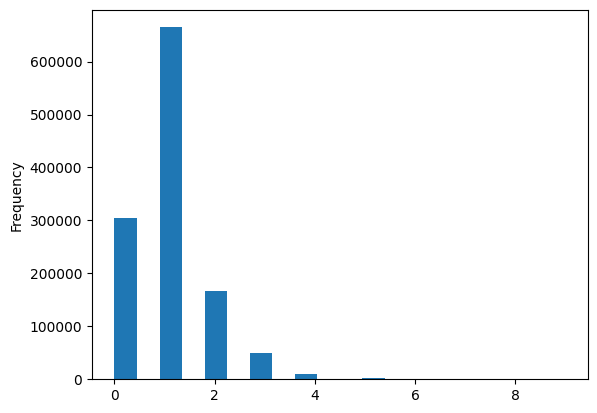

In [38]:
# Посмотрим распредение данных нашего столбца на гарфике
df_train_1['previous_claims'].plot(kind = 'hist', bins =20)

In [39]:
#  annual_income
# Заменим на среднее
df_train_1['annual_income'].fillna(df_train_1['annual_income'].mean(), inplace= True)

<ipython-input-39-5010afff63e6>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_1['annual_income'].fillna(df_train_1['annual_income'].mean(), inplace= True)


<Axes: ylabel='Frequency'>

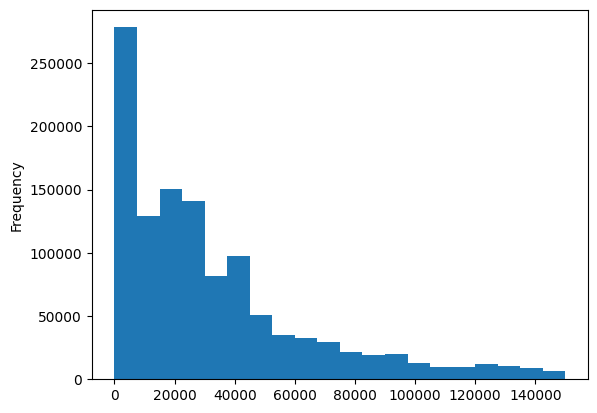

In [40]:
df_train['annual_income'].plot(kind = 'hist', bins =20)

In [41]:
# Произведем замену столбца "number_of_dependents" на mode (количество иждивенцев)
# Найдем часто используемое число
df_train_1['number_of_dependents'].value_counts()

,count
number_of_dependents,
3.0,221475
4.0,220340
0.0,218124
2.0,215313
1.0,215076


In [42]:
#  проверим
df_train_1['number_of_dependents'].mode()

,number_of_dependents
0,3.0


In [43]:
children_mode= df_train_1['number_of_dependents'].mode().iloc[0];
children_mode

3.0

In [44]:
# заменяем
df_train_1['number_of_dependents']=df_train_1['number_of_dependents'].fillna(children_mode)
df_train_1['number_of_dependents'].isna().sum()

0

<Axes: ylabel='Frequency'>

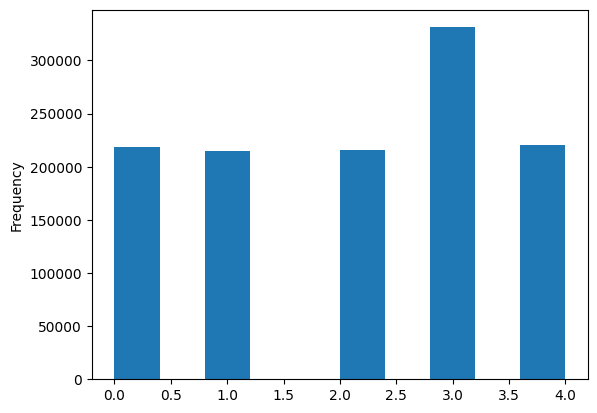

In [45]:
# Посмотрим график
df_train_1['number_of_dependents'].plot(kind = 'hist', bins =10)

In [46]:
# Произвелем замену столбца "age" на mode (). Так как это только 2 процента данных.
# Найдем часто используемое число
df_train_1['age'].value_counts()

,count
age,
53.0,26354
61.0,26218
39.0,26042
64.0,25990
57.0,25971
43.0,25966
62.0,25849
46.0,25756
33.0,25728


In [47]:
df_train_1['age'].isna().sum()

18705

<Axes: ylabel='Frequency'>

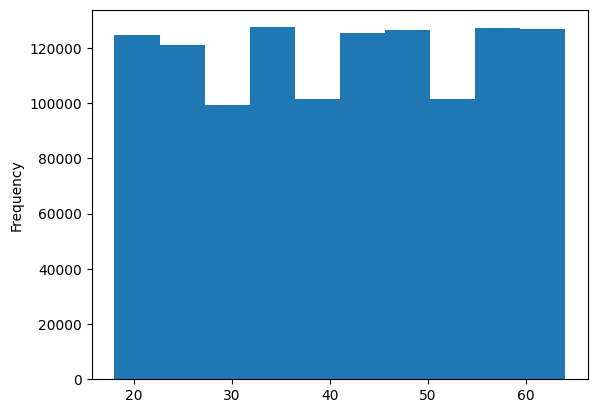

In [48]:
df_train_1['age'].plot(kind = 'hist', bins =10)

In [49]:
df_train_1['age'].mode()

,age
0,53.0


In [50]:
age_mode = df_train_1['age'].mode().iloc[0]
age_mode

53.0

In [51]:
# Производим замену в нашем столбце
df_train_1['age']=df_train_1['age'].fillna(age_mode)
df_train_1['age'].isna().sum()

0

In [52]:
# vehicle_age
# Посмотрим столбец "vehicle_age"

df_train_1['vehicle_age'].value_counts()

,count
vehicle_age,
17.0,62577
0.0,61615
11.0,61483
18.0,61399
10.0,61351
15.0,60817
14.0,60815
12.0,60718
19.0,60495


In [53]:
# Посмотрим медиану и среднее
df_train_1['vehicle_age'].mean()


9.569888682776748

In [54]:
df_train_1['vehicle_age'].median()

10.0

In [55]:
df_train_1['vehicle_age'].mode()

,vehicle_age
0,17.0


In [56]:
# Заменим на медиану она более устойчива к выбросам
df_train_1['vehicle_age'].fillna(df_train_1['vehicle_age'].mean(), inplace= True)

<ipython-input-56-bb5e9bd5510a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_1['vehicle_age'].fillna(df_train_1['vehicle_age'].mean(), inplace= True)


In [57]:
df_train_1['vehicle_age'].isna().sum()

0

In [58]:
# В столбце "insurance_duration" удалим пропущенное зачение, т.к очень мало в отношее к общему количеству строк
df_train_1= df_train_1.dropna(subset= 'insurance_duration',  axis= 0)

In [59]:
# Проверим на пропуски
df_train_1.isna().sum()

,0
id,0
age,0
annual_income,0
number_of_dependents,0
health_score,0
previous_claims,0
vehicle_age,0
credit_score,0
insurance_duration,0
premium_amount,0


In [60]:
# Удалим не нужный столбец
del  df_train_1['id']

# <font color='#11a642' size='6'> **Подготовка данных к обучению**

# <font color='#11a642' size='6'> **Разделите данные на трейн и тест**

In [61]:
X = df_train_1.drop(columns=[target])
y = df_train_1[target]

In [62]:
# разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

# <font color='#11a642' size='6'> **Построение моделей машинного обучения**

## <font color='#11a642' size='5'> Построение линейной регрессии и huber регрессии

In [63]:
# Преобразуем числовые признаки на обучающей выборке
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Линейная регрессия

In [64]:
# Обучение модели
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)

LinearRegression()

In [65]:
regressor.coef_, regressor.intercept_

(array([ -1.9872971 , -16.07508389,   1.12551622,  13.05847828,
         35.4531517 ,   0.40545768, -25.09935227,  -0.79961841]),
 1103.1940272854451)

In [66]:
# Посмотрим предсказание и оценку модели на тест выборке
y_pred_test= regressor.predict(X_test_scaled)
y_pred_train= regressor.predict(X_train_scaled)

In [67]:
# Посчитаем средне квадратичную ошибку
mse_test = mean_squared_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
print(f"MSE on Test Data = {mse_train:.0f} and MSE on Train Data  ={mse_test:.0f}")

MSE on Test Data = 746931 and MSE on Train Data  =743014


In [68]:
# Рассчитаем RMSE
rmse_test = root_mean_squared_error(y_test, y_pred_test)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
print(f"MSE on Test Data = {rmse_train:.0f} and MSE on Train Data  ={rmse_test:.0f}")

MSE on Test Data = 864 and MSE on Train Data  =862


In [69]:
#  Посмотрим дисперсию и среднее
np.var(y_test), np.mean(y_test)

(745118.9491923326, 1099.9482458333334)

In [70]:
# Посторим мпетрику r2
r2_score(y_test, y_pred_test)

0.002824610782227399

Сравнив дисперсию и MSE видим что модель обучилась есть небольшие ошибки
А сравнивая срденее и RMSE разница получилась больше.(система ошибается больше). Посмотрев коффициент детерминации (r2) делаем вывод, модель линейной регрессии не очень подходит для данного дата фрейма.

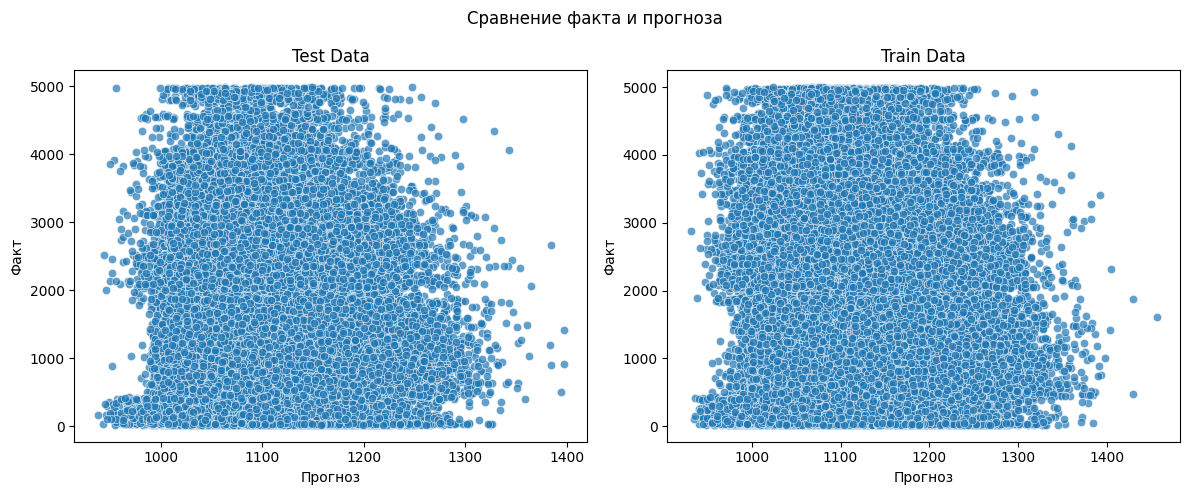

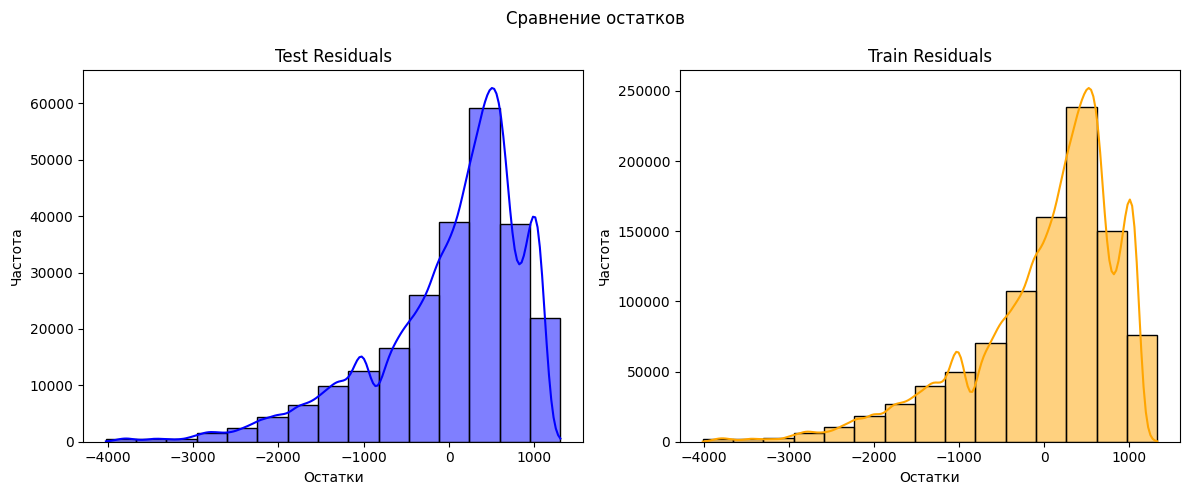

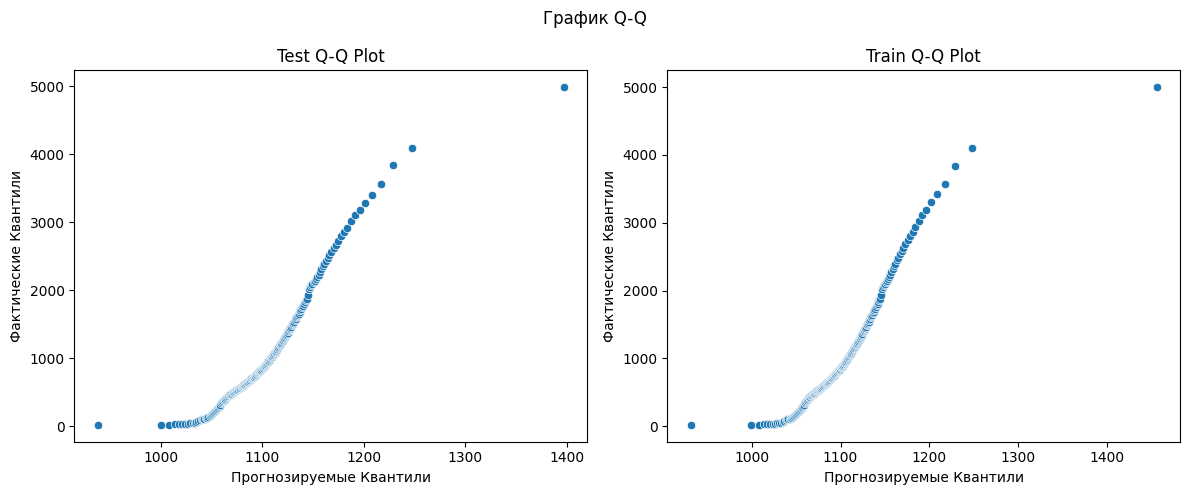

In [71]:
# Проведем сравнение полученных данных с нашими исходными данными на графие
get_plots(regressor, X_train_scaled, X_test_scaled, y_train, y_test)

Вывод. Видимо линейная регрессия не очень подходит для данной выборки. Например на гарфике, где просмотриваются зависимости Прогназируемых и Фактических квантилей. Фак 2000 а соответсующий ему Прогноз меньше 1200.

# Huber регрессия

In [72]:
# Обучение Huber регрессии
huber_model= HuberRegressor()
huber_model.fit(X_train_scaled, y_train)


HuberRegressor()

In [73]:
# Предсказание и оценка модели
y_pred_test= huber_model.predict(X_test_scaled)
y_pred_train= huber_model.predict(X_train_scaled)

In [74]:
# MAPE
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

In [75]:
    # SMAPE
    smape_test = 100 * np.mean(2 * np.abs(y_test - y_pred_test) / (np.abs(y_test) + np.abs(y_pred_test)))
    smape_train = 100 * np.mean(2 * np.abs(y_train - y_pred_train) / (np.abs(y_train) + np.abs(y_pred_train)))

In [76]:
#  Сранвим полученные показатели с тестом
mape_test, mape_train, smape_test, smape_train

(249.67264912834958, 250.04678051752265, 64.44289438540422, 64.56640601709924)

In [77]:
# Посторим мпетрику r2
r2_score(y_test, y_pred_test)

-0.036668889576236374

### <font color='#11a642' size='4'> выведите важность признаков для лучшей модели (то есть надо сравнить линейную регрессию и huber регрессию) и для лучше модели вывести feature_importance

*Вывод. Сравнивая линейную регрессию и huber регрессию,huber регрессия дает лучше результат, но оба варианта далеки от идеального.

In [78]:
# посмотрим коффициенты корреляции, что бы определить занчимые признаки.
df_train_1.corr()

,age,annual_income,number_of_dependents,health_score,previous_claims,vehicle_age,credit_score,insurance_duration,premium_amount
age,1.000000,0.000130,0.001079,0.001022,0.001669,-0.002435,0.002293,-0.000184,-0.002500
annual_income,0.000130,1.000000,0.003464,0.024040,0.035647,-0.000490,-0.186723,0.000372,-0.012091
number_of_dependents,0.001079,0.003464,1.000000,0.004677,-0.002422,0.001523,-0.003103,-0.000319,0.000902
health_score,0.001022,0.024040,0.004677,1.000000,0.001778,0.000235,0.009947,0.002374,0.013976
previous_claims,0.001669,0.035647,-0.002422,0.001778,1.000000,-0.000977,0.028778,0.002505,0.039364
vehicle_age,-0.002435,-0.000490,0.001523,0.000235,-0.000977,1.000000,0.000471,0.003132,0.000391
credit_score,0.002293,-0.186723,-0.003103,0.009947,0.028778,0.000471,1.000000,0.000446,-0.024471
insurance_duration,-0.000184,0.000372,-0.000319,0.002374,0.002505,0.003132,0.000446,1.000000,-0.000028
premium_amount,-0.002500,-0.012091,0.000902,0.013976,0.039364,0.000391,-0.024471,-0.000028,1.000000


*Вывод. Посмотрев корреляцию видим что в нашем наборе нет коррелирующих признаков.

## <font color='#11a642' size='5'> Построение модели knn c подбором наилучших гиперпараметров (gridsearch)

In [79]:
n_neighbors= 3
# разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [80]:
model = KNeighborsClassifier(n_neighbors=n_neighbors)
model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

### <font color='#11a642' size='4'> Оценка качества модели KNN

In [109]:
score = model.score(X_test_scaled, y_test)
print('The accurasy is', score)

The accurasy is 0.002


accurasy покажывает нам долю верных ответов которые дает наша модель. Согласно полученному результату наша модель дает верных ответов очень мало.

In [104]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Пробуем разные значения K
k_values = range(1, 21)
cross_val_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    cross_val_scores.append(scores.mean())

# Оптимальное значение K
optimal_k = k_values[cross_val_scores.index(max(cross_val_scores))]
print(f'Оптимальное значение K: {optimal_k}')

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklea

Оптимальное значение K: 1


In [105]:
# Обучение модели с оптимальным K
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [108]:
from sklearn.metrics import accuracy_score, classification_report

# Предсказание на тестовой выборке
y_pred = knn.predict(X_test)

# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')


Точность модели: 0.012079166666666667


In [110]:
# accuracy с 3 соседями
score

0.002

* В итоге результат получился лучше после поиска К.

# <font color='#11a642' size='4'> Ваши выводы
- Линейная и huber регрессии давали очень низкие показатели. И посмотрев на графиках есть предположение, что данные модели не походят в нашу дата фрейму.При рассмотрении модели knn соседей, анализ показал очень маленькое количоство верных ответов модели. Возможно при большом количестве признаков может возникнуть проблема совпадения метрической и смысловой близости объектов.
